# Damage Identification using Machine Learning

After a hurricane, damage assessment is critical to emergency managers and first responders so that resources can be planned and allocated appropriately. One way to gauge the damage extent is to detect and quantify the number of damaged buildings, which is traditionally done through driving around the affected area. This process can be labor intensive and time-consuming. In this paper, utilizing the availability and readiness of satellite imagery, we propose to improve the efficiency and accuracy of damage detection via image classification algorithms. From the building coordinates, we extract their aerial-view windows of appropriate size and classify whether a building is damaged or not. We demonstrate the result of our method in the case study of 2017 Hurricane Harvey.




* train_another : the training data; 5000 images of each class
* validation_another: the validation data; 1000 images of each class
* test_another : the unbalanced test data; 8000/1000 images of damaged/undamaged classes
* test : the balanced test data; 1000 images of each class

All images are in JPEG format, the class label is the name of the super folder containing the images

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
def getImages(folder_path):
    data_dir = pathlib.Path(folder_path) 
    total_count = len(list(data_dir.glob('*/*.jpeg')))
    print("Total Count of Images (including damaged and non damaged): ", total_count)
    return data_dir

In [3]:
training_folder_path = '../data/Post-hurricane/train_another/'
validation_folder_path = '../data/Post-hurricane/validation_another/'
test_folder_path = '../data/Post-hurricane/test_another/'

trainingdata_dir = getImages(training_folder_path)
validationdata_dir = getImages(validation_folder_path)
testdata_dir = getImages(test_folder_path)

Total Count of Images (including damaged and non damaged):  10000
Total Count of Images (including damaged and non damaged):  2000
Total Count of Images (including damaged and non damaged):  9000


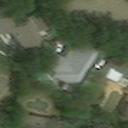

In [4]:
damaged_image = list(trainingdata_dir.glob('damage/*'))
PIL.Image.open(str(damaged_image[0]))

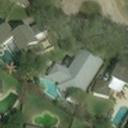

In [5]:
no_damaged_image = list(trainingdata_dir.glob('no_damage/*'))
PIL.Image.open(str(no_damaged_image[0]))

## Load using keras.preprocessing

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  trainingdata_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 2 classes.
Using 8000 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  validationdata_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2000 files belonging to 2 classes.
Using 400 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['damage', 'no_damage']


## Visualisation of first 9 pictures

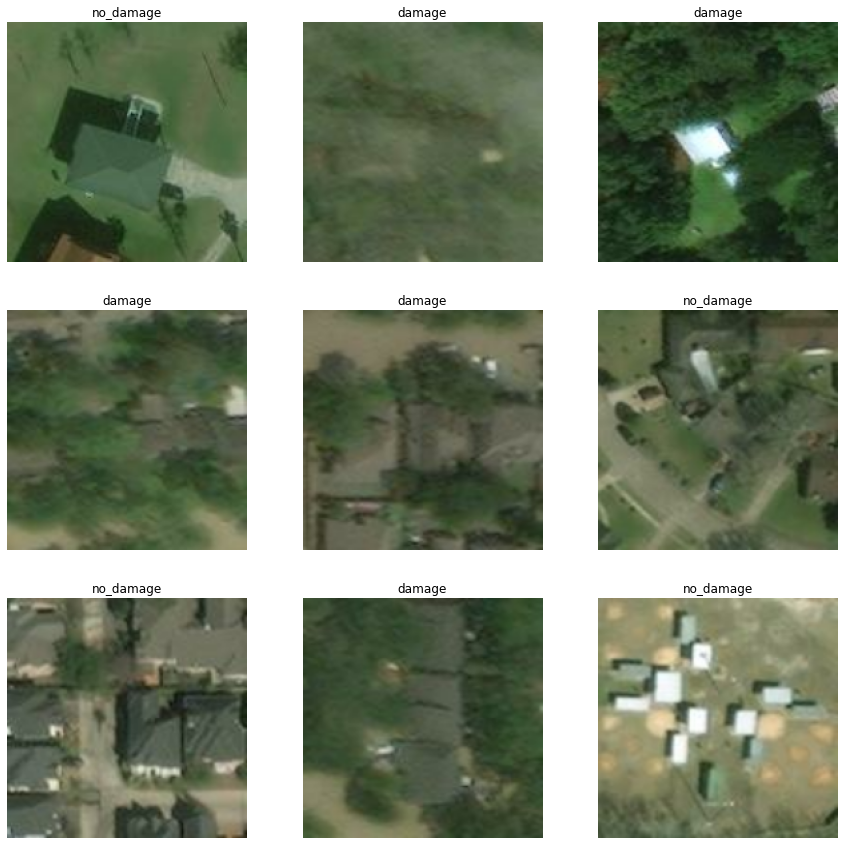

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape) #batch of 32 images of shape 180x180x3
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [12]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255) 
#changing the color scale from RGB [0,255] to small values for NN [0,1]

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.07982142 0.75282335


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [17]:

epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
250/250 [==============================] - 108s 428ms/step - loss: 0.6058 - accuracy: 0.6623 - val_loss: 0.3275 - val_accuracy: 0.8925
Epoch 2/5
250/250 [==============================] - 109s 438ms/step - loss: 0.3120 - accuracy: 0.8847 - val_loss: 0.2528 - val_accuracy: 0.9100
Epoch 3/5
250/250 [==============================] - 106s 425ms/step - loss: 0.2199 - accuracy: 0.9106 - val_loss: 0.2031 - val_accuracy: 0.9250
Epoch 4/5
250/250 [==============================] - 103s 410ms/step - loss: 0.1547 - accuracy: 0.9380 - val_loss: 0.2236 - val_accuracy: 0.9075
Epoch 5/5
250/250 [==============================] - 100s 398ms/step - loss: 0.1332 - accuracy: 0.9429 - val_loss: 0.2453 - val_accuracy: 0.8975


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0

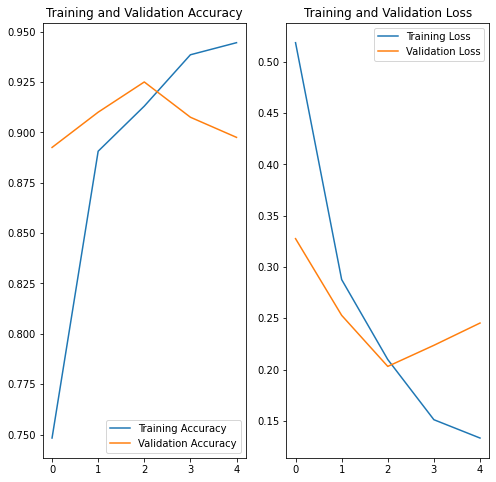

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Prediction

In [44]:
def predict_damage(filepath):
    img = keras.preprocessing.image.load_img(
        filepath, target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    
    return PIL.Image.open(str(filepath))


In [45]:
damage_test = list(testdata_dir.glob('damage/*'))
nodamage_test = list(testdata_dir.glob('no_damage/*'))

#### Predict Damage

This image most likely belongs to damage with a 83.93 percent confidence.


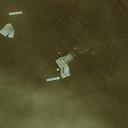

In [50]:
predict_damage(damage_test[3])

This image most likely belongs to no_damage with a 100.00 percent confidence.


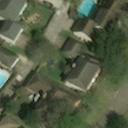

In [52]:
predict_damage(nodamage_test[1])